## Spatial tissue niche discovery (single-modality spatial data)

Here we will use slideseqv2_mouse_hippocampus datasets as an example to illustrate how Garfield performs spatial tissue niche discovery for multiple batches. Data access: https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2.

In [1]:
import os

os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scanpy as sc

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'0.3.1'

In [3]:
# Load data
# Define paths
st_data_folder_path = "/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data" # spatially resolved transcriptomics data

dataset = "slideseqv2_mouse_hippocampus"
cell_type_key = "cell_type"

adata = sc.read_h5ad(f"{st_data_folder_path}/{dataset}.h5ad")
adata.var_names_make_unique(join="++")
adata

AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'cell_type', 'batch'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
# check the celltype information of this dataset
adata.obs['cell_type'].value_counts()

cell_type
CA1_CA2_CA3_Subiculum       7649
DentatePyramids             6606
Astrocytes                  6543
Interneurons                3672
Oligodendrocytes            3602
Subiculum_Entorhinal_cl2    2896
Endothelial_Stalk           1991
Subiculum_Entorhinal_cl3    1985
Polydendrocytes             1449
Endothelial_Tip             1317
Microglia                   1298
Mural                       1027
Neurogenesis                 938
Ependymal                    813
Name: count, dtype: int64

In [6]:
# check the batch information of this dataset
adata.obs['batch'].value_counts()

batch
sample1    41786
Name: count, dtype: int64

In [5]:
# Ensure adata.X is counts.
adata.X = adata.layers['counts'].copy()
adata.X.max()

169.0

## Integrating spatially resolved transcriptomics data using Garfield

For spatial niche discovery from spatially resolved transcriptomics data, we should adjust the following paremeters,
and all parameter introductions can be found in [Garfield_Model_Parameters](https://github.com/zhou-1314/Garfield/blob/main/Garfield_Model_Parameters.md).

In [7]:
# set workdir
workdir = '/home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spRNA_mouse_hippocampus' 
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=adata, 
    profile='spatial',  
    data_type='single-modal',
    sample_col=None,  # only one batch, so set it as `None`
    weight=0.5,

    ## Preprocessing options
    graph_const_method='mu_std',
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    n_components=50,
    n_neighbors=5,
    metric='euclidean',  
    svd_solver='arpack',
    # datasets
    adj_key='connectivities',
    
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,

    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=False,
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2, 
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=False,
    used_DSBN=False,
    used_mmd=False,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=128, # None
    # loss parameters
    include_edge_recon_loss=True,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_loss=1.0,
    lambda_gene_expr_recon=300.,
    lambda_edge_recon=500.,  # We hope that the model can learn more graph structure information, so we increase this hyperparameters.
    lambda_omics_recon_mmd_loss=0.2,
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spRNA_mouse_hippocampus


In [8]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---
------Calculating spatial graph...
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [9]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Number of training nodes: 37607
Number of validation nodes: 4179
Number of training edges: 247173
Number of validation edges: 27463
Edge batch size: 4096
Node batch size: 128

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.8235; val_auprc_score: 0.8162; val_best_acc_score: 0.7448; val_best_f1_score: 0.7624; train_kl_reg_loss: 45.6248; train_edge_recon_loss: 347.0444; train_gene_expr_recon_loss: 61696.2382; train_lambda_latent_contrastive_instanceloss: 7.1103; train_lambda_latent_contrastive_clusterloss: 3.6218; train_global_loss: 62099.6395; train_optim_loss: 62099.6395; val_kl_reg_loss: 67.9875; val_edge_recon_loss: 349.5279; val_gene_expr_recon_loss: 58776.0619; val_lambda_latent_contrastive_instanceloss: 6.5359; val_lambda_latent_contrastive_clusterloss: 3.3872; val_global_loss: 59203.5006; val_optim_loss: 59203.5006
Epoch 2/100 |--------------------| 2.0% val_auroc_score: 0.8769; val_auprc_score: 0.8711; val_best_acc_

In [10]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

## Visualize Garfield Latent Space

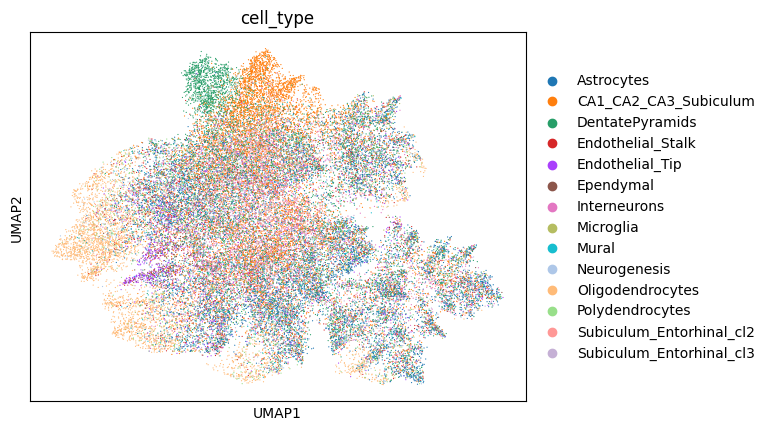

In [11]:
## cell distribution colored by original celltype
sc.pl.umap(model.adata, color=['cell_type'], show=True, size=3)

In [12]:
# Compute latent Leiden clustering
latent_leiden_resolution = 1.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
latent_key = "garfield_latent"

sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)
len(model.adata.obs[latent_cluster_key].unique())

16

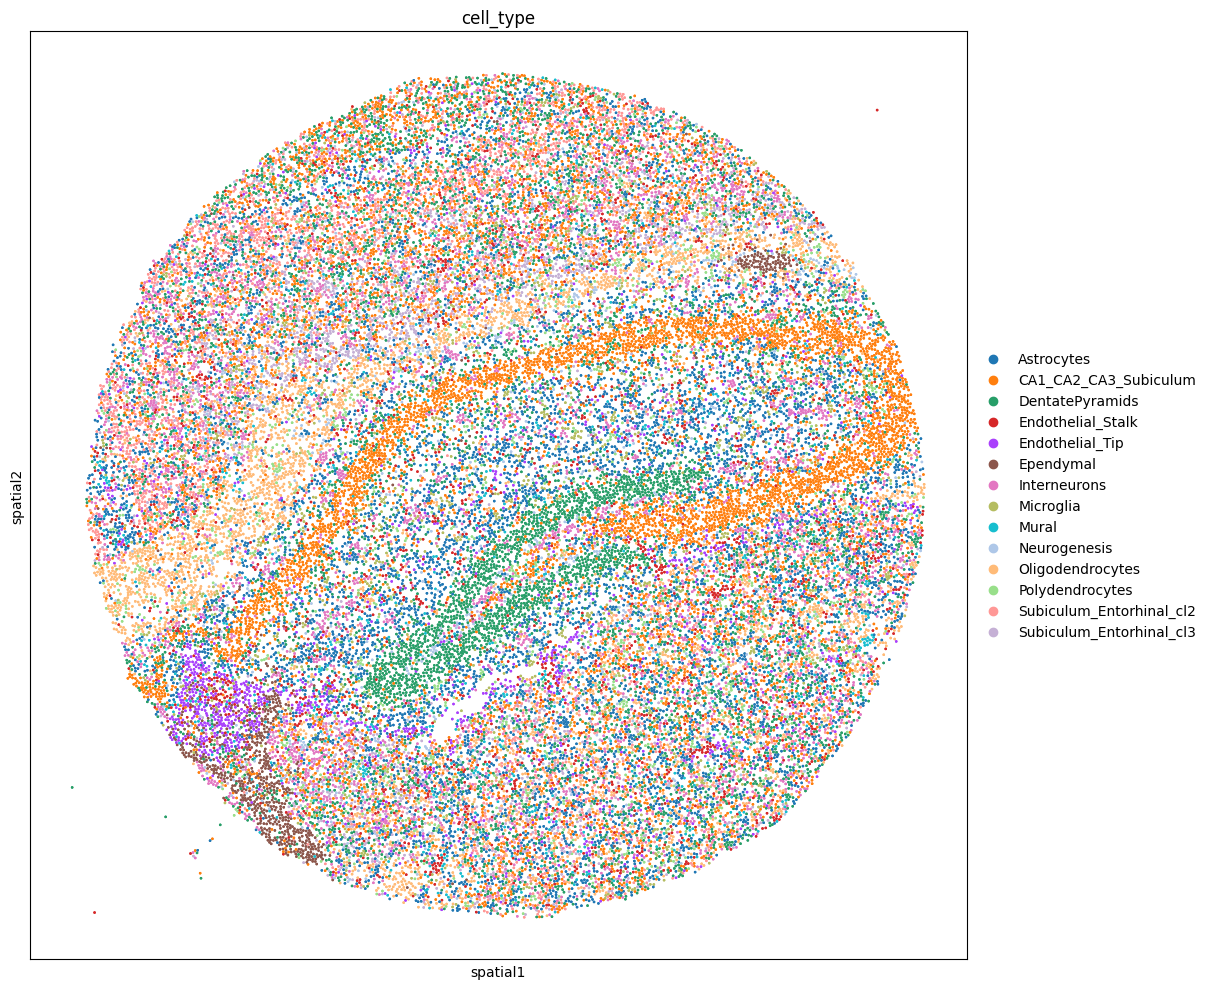

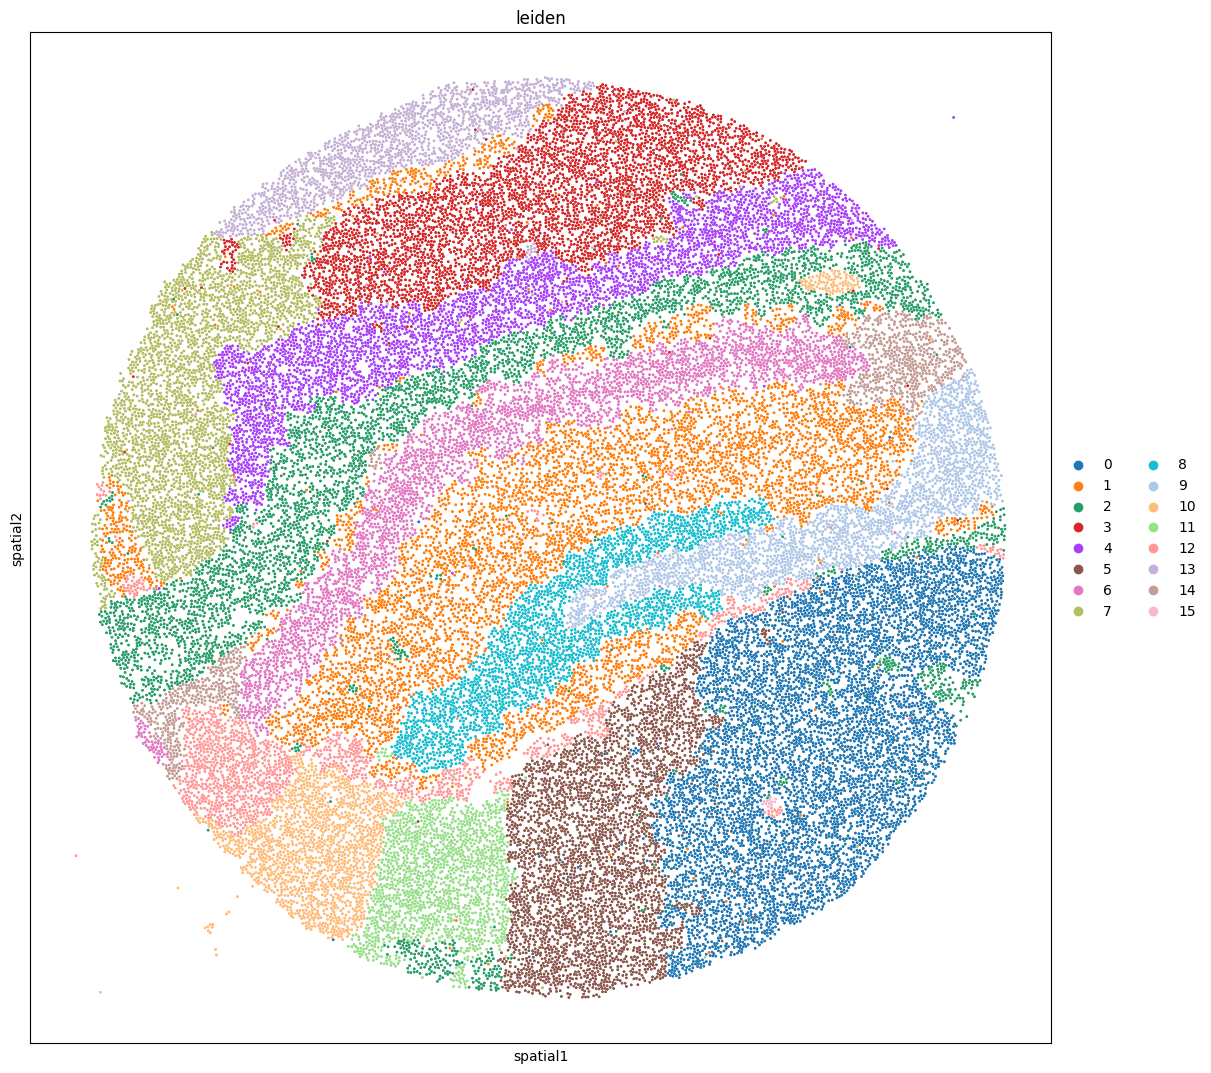

In [13]:
### 分样本展示空间位置
import squidpy as sq

# Visualize cell-level annotated data in physical space
## celltype 
sq.pl.spatial_scatter(model.adata, color='cell_type', shape=None, figsize=(12, 12))    

## niches
sq.pl.spatial_scatter(model.adata, color='leiden', shape=None, figsize=(12, 12))     

In [14]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")

Model saved successfully using pickle at /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spRNA_mouse_hippocampus/model/attr.pkl
